# Sensitivity analysis

In [168]:
from SALib.sample import saltelli, fast_sampler
from SALib.analyze import sobol, fast, morris
from SALib.sample.morris import sample
import numpy as np, matplotlib.pyplot as plt, matplotlib.font_manager as fm, os
from SALib.plotting.bar import plot as barplot
from scipy.integrate import odeint
from mpl_toolkits.mplot3d.axes3d import Axes3D
from SALib.test_functions import Ishigami
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
plt.rcParams['figure.figsize'] = (20,8)

In [169]:
def lorenz(x, y, z, r, s=10, b=2.667):
    '''
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    '''
    x_dot = s * (y - x)
    y_dot = r * x - y - x * z
    z_dot = x * y - b * z
    return x_dot, y_dot, z_dot

In [170]:
def distance(x, y):
    return np.sqrt(np.sum(np.square(x - y)))

In [171]:
dt = 0.01
# number of Lorenz function points to generate
num_steps = 1000

# Need one more for the initial values
xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)

# Set initial values
xs[0], ys[0], zs[0] = (0., 1., 0.)

Points = np.empty([num_steps, 3])

In [172]:
# Ideal Lorenz attractor
for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i], 24.08)
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)
    a = np.array((x_dot, y_dot, z_dot))
    Points[i] = a


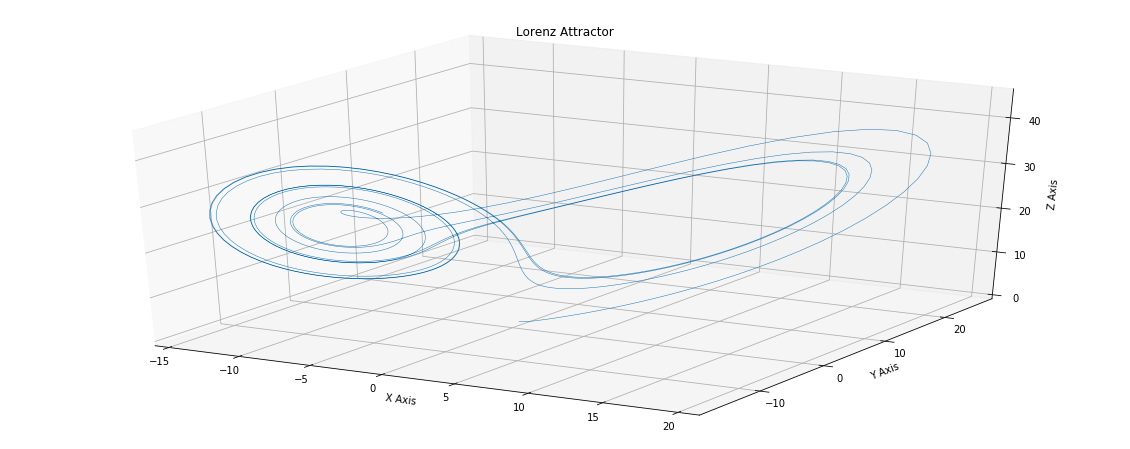

In [173]:
# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")
plt.show()

In [174]:
problem = {
    "num_vars": 4,
    "names": ['X', 'y', 'z', 'r'],
    "bounds": [[-1, 1], [-1, 1], [-1, 1], [1, 50]]
}

In [175]:
# Generate samples for sobol analysis
sobol_param_values = saltelli.sample(problem, 100)
SobolPoints = []

# Generate samples for fast analysis
fast_param_values = fast_sampler.sample(problem, 100)
FastPoints = []

In [176]:
for j in range(len(sobol_param_values)):
    # reset values and set starting point based on values from sampler
    x = sobol_param_values[j]
    xs = np.empty(num_steps + 1)
    ys = np.empty(num_steps + 1)
    zs = np.empty(num_steps + 1)
    xs[0], ys[0], zs[0] = (x[0], x[1], x[2])
    for i in range(num_steps):
        # calculate next points of Lorenz function
        x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i], x[3])
        xs[i + 1] = xs[i] + (x_dot * dt)
        ys[i + 1] = ys[i] + (y_dot * dt)
        zs[i + 1] = zs[i] + (z_dot * dt)
        # calculate distance beetwen current Lorenz system and ideal case
        a = distance(np.array((x_dot, y_dot, z_dot)), Points[i])
        SobolPoints.append(a)

In [177]:
# calculate sobol analysis
SobolArray = np.asarray(SobolPoints)
sensitivity = sobol.analyze(problem, SobolArray)
print("Sobol Sensitivity S1:")
print(sensitivity["S1"])
print("Sobol Sensitivity ST:")
print(sensitivity["ST"])

Sobol Sensitivity S1:
[0.04102818 0.08309332 0.12576392 0.16806931]
Sobol Sensitivity ST:
[0.0061234  0.02407639 0.05252346 0.0890781 ]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000019E24583788>,
      dtype=object)

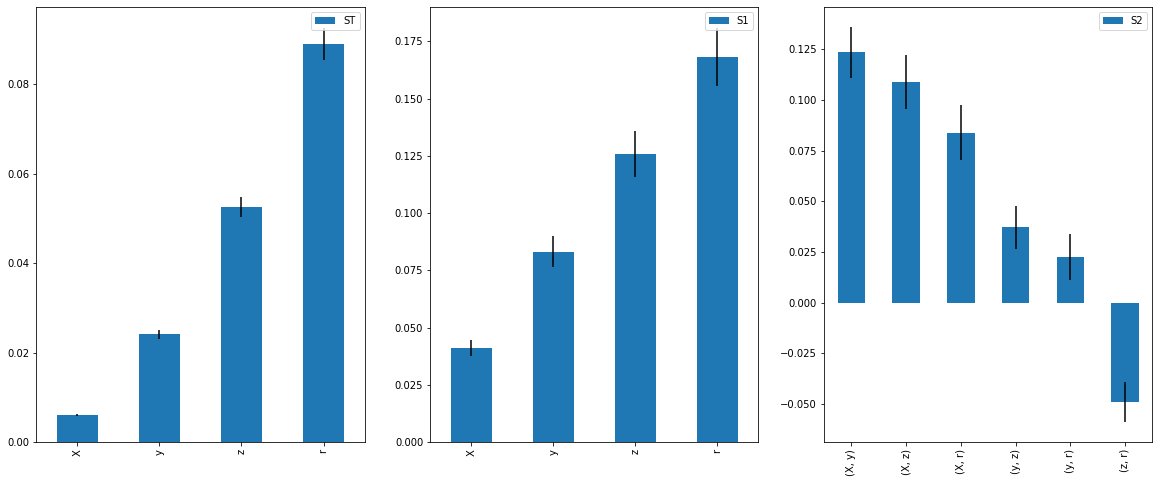

In [178]:
sensitivity.plot()

In [179]:
for j in range(len(fast_param_values)):
    x = fast_param_values[j]
    xs = np.empty(num_steps + 1)
    ys = np.empty(num_steps + 1)
    zs = np.empty(num_steps + 1)
    xs[0], ys[0], zs[0] = (x[0], x[1], x[2])
    for i in range(num_steps):
        x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i], x[3])
        xs[i + 1] = xs[i] + (x_dot * dt)
        ys[i + 1] = ys[i] + (y_dot * dt)
        zs[i + 1] = zs[i] + (z_dot * dt)
        a = distance(np.array((x_dot, y_dot, z_dot)), Points[i])
        FastPoints.append(a)

In [180]:
# calculate fast analysis
fast_sensitivity = fast.analyze(problem, np.asarray(FastPoints))
print("Fast Sensitivity Analysis: ")
print(fast_sensitivity)

Fast Sensitivity Analysis: 
{'S1': [1.4500405059120956e-07, 8.925745903756105e-09, 2.0217720269137777e-07, 6.65453798267922e-08], 'ST': [0.014472003719233073, 0.01329776800808491, 0.013342027214988894, 0.013819897715591667], 'names': ['X', 'y', 'z', 'r']}


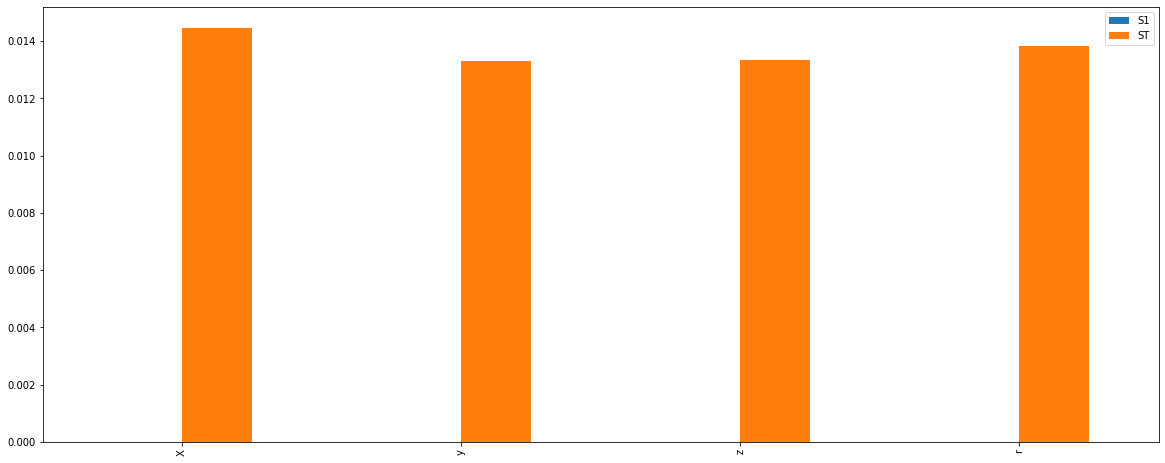

In [181]:
fast_sensitivity.plot()

In [182]:
morris_param_values = sample(problem, 100,num_levels=4)
MorrisPoints = []
for j in range(len(morris_param_values)):
    x = morris_param_values[j]
    xs = np.empty(num_steps + 1)
    ys = np.empty(num_steps + 1)
    zs = np.empty(num_steps + 1)
    xs[0], ys[0], zs[0] = (x[0], x[1], x[2])
    for i in range(1):
        x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i], x[3])
        xs[i + 1] = xs[i] + (x_dot * dt)
        ys[i + 1] = ys[i] + (y_dot * dt)
        zs[i + 1] = zs[i] + (z_dot * dt)
        a = distance(np.array((x_dot, y_dot, z_dot)), Points[i])
        MorrisPoints.append(a)


In [183]:
print('Morris Sensitivity:')
morris_sensitivity = morris.analyze(problem, morris_param_values, np.asarray(MorrisPoints), conf_level=0.95,
                                    print_to_console=True,
                                    num_levels=4, num_resamples=100)

Morris Sensitivity:
Parameter                         Mu_Star         Mu    Mu_Star_Conf      Sigma
X                                  29.448      1.453           2.533     33.055
y                                  10.633     -8.896           1.204      8.248
z                                   1.045     -0.886           0.117      0.883
r                                  26.096     26.096           3.178     16.380


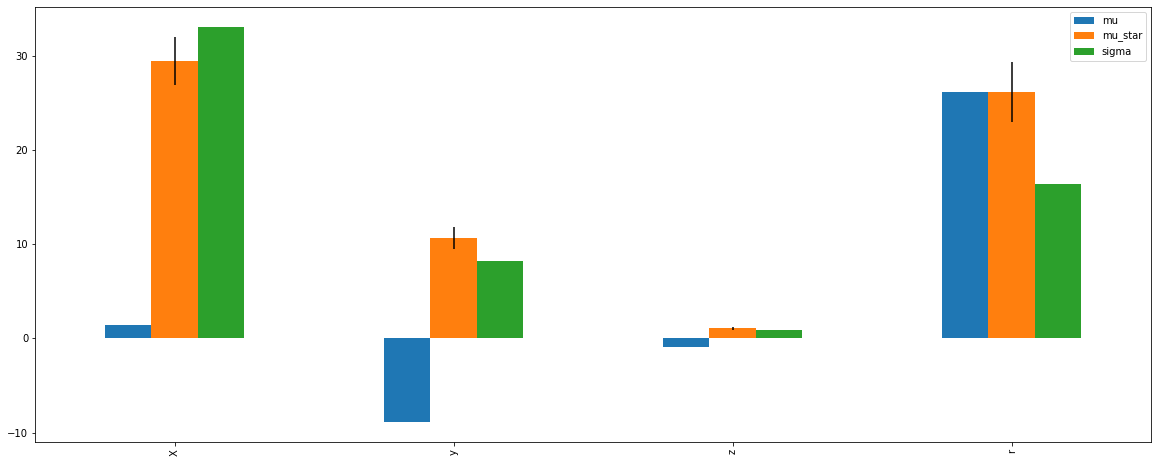

In [184]:
morris_sensitivity.plot()